# PCA

## PCA nad Skupom Iris

### Ucitavanje paketa

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

### Preprocesiranje podataka

In [6]:
df = pd.read_csv('Data/iris.csv')

feature_names = df.columns[:4].tolist()
target_name = df.columns[4]

X = df[feature_names]
y = df[target_name]

scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=feature_names)
X.head()

,sepal.length,sepal.width,petal.length,petal.width
0,-0.900681,1.019004,-1.340227,-1.315444
1,-1.143017,-0.131979,-1.340227,-1.315444
2,-1.385353,0.328414,-1.397064,-1.315444
3,-1.506521,0.098217,-1.283389,-1.315444
4,-1.021849,1.249201,-1.340227,-1.315444


### Primena PCA

In [45]:
pca = PCA()
pca.fit(X)

pca_columns = [f'pca_{i}' for i in range(pca.n_components_)]
X_transformed = pd.DataFrame(pca.transform(X), columns=pca_columns)
X_transformed.head()

,pca_0,pca_1,pca_2,pca_3
0,-2.264703,0.480027,-0.127706,-0.024168
1,-2.080961,-0.674134,-0.234609,-0.103007
2,-2.364229,-0.341908,0.044201,-0.028377
3,-2.299384,-0.597395,0.091290,0.065956
4,-2.389842,0.646835,0.015738,0.035923


In [46]:
print('Jednacine po kojima se racunaju glavne komponente:')
for i, component in enumerate(pca.components_):
    eq = ' + '.join([ '(' + str(round(coef,2)) + feature_names[j] + ')' for j, coef in enumerate(component)])
    print(f'pca_{i} = {eq}')

Jednacine po kojima se racunaju glavne komponente:
pca_0 = (0.52sepal.length) + (-0.27sepal.width) + (0.58petal.length) + (0.56petal.width)
pca_1 = (0.38sepal.length) + (0.92sepal.width) + (0.02petal.length) + (0.07petal.width)
pca_2 = (-0.72sepal.length) + (0.24sepal.width) + (0.14petal.length) + (0.63petal.width)
pca_3 = (-0.26sepal.length) + (0.12sepal.width) + (0.8petal.length) + (-0.52petal.width)


In [47]:
print('Kolicina varijanse svake od glavnih komponenata:')
for pca_i, ev in zip(pca_columns, pca.explained_variance_):
    print(f'{pca_i}: {round(ev, 2)}')

Kolicina varijanse svake od glavnih komponenata:
pca_0: 2.94
pca_1: 0.92
pca_2: 0.15
pca_3: 0.02


In [48]:
print('Procenat varijanse svake od glavnih komponenata:')
for pca_i, evr in zip(pca_columns, pca.explained_variance_ratio_):
    print(f'{pca_i}: {round(evr, 2)}')

Procenat varijanse svake od glavnih komponenata:
pca_0: 0.73
pca_1: 0.23
pca_2: 0.04
pca_3: 0.01


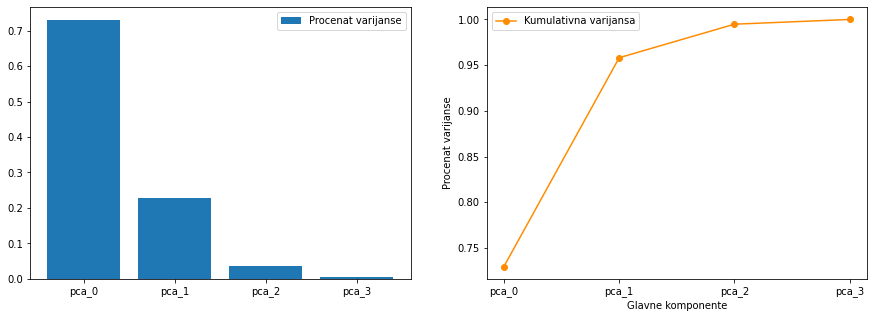

In [59]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.bar(pca_columns, pca.explained_variance_ratio_, label='Procenat varijanse')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(pca_columns,  np.cumsum(pca.explained_variance_ratio_), color='darkorange',
         label='Kumulativna varijansa',  marker='o')
plt.xlabel('Glavne komponente')
plt.ylabel('Procenat varijanse')
plt.legend()
plt.show()

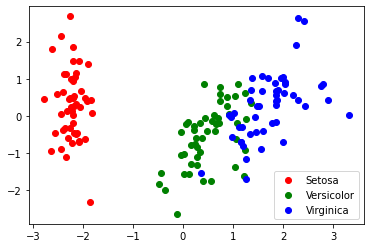

In [65]:
plt.figure()

colors = ['red', 'green', 'blue']

classes = np.unique(y)
for i, class_name in enumerate(classes):
    class_samples = X_transformed.iloc[y[y == class_name].index]
    plt.scatter(
        class_samples['pca_0'], class_samples['pca_1'], 
        color=colors[i], label=class_name
    )
    
plt.legend()
plt.show()

## Klasifikacija sa i bez PCA

### Ucitavanje paketa

In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

### Preprocesiranje podataka

In [84]:
df = pd.read_csv('Data/car.csv')

feature_names = df.columns[1:].tolist()
target_name = df.columns[0]

X = df[feature_names]
y = df[target_name]

scaler = StandardScaler()
scaler.fit(X)
X = pd.DataFrame(scaler.transform(X), columns=feature_names)

pca = PCA()
pca.fit(X)

pca_columns = [f'pca_{i}' for i in range(len(feature_names))]
X_transformed = pd.DataFrame(pca.transform(X), columns=pca_columns)

for pca_i, evr in zip(pca_columns, pca.explained_variance_ratio_):
    print(f'{pca_i}: {round(evr, 2)}')

pca_0: 0.81
pca_1: 0.15
pca_2: 0.03
pca_3: 0.01
pca_4: 0.01


Prve dve glavne komponente opisuju vise od $95\%$ varijansi. U nastavku klasifikacije mozemo da izbacimo ostale komponente.

In [85]:
X_transformed = X_transformed[['pca_0', 'pca_1']]
X_transformed.head()

,pca_0,pca_1
0,2.349159,-0.542004
1,3.174141,-0.682623
2,2.743127,-0.954471
3,2.555517,-0.651473
4,2.604323,-1.107031


### Treniranje i Evaluacija Dva Modela

In [109]:
def classify(X, y):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.33, 
        stratify=y, random_state=42
    )
    
    params = {
        'n_neighbors': range(3, 20, 2),
        'p': [1, 2],
        'weights': ['uniform', 'distance']
    }
    
    clf = GridSearchCV(KNeighborsClassifier(), param_grid=params, cv=5)
    clf.fit(X_train, y_train)
    y_pred_train = clf.predict(X_train)
    y_pred_test = clf.predict(X_test)
    
    print('Najbolji parametri', clf.best_params_)
    
    print('Tacnost modela (Train):')
    print(round(accuracy_score(y_train, y_pred_train), 2))
    print('Tacnost modela (Test):')
    print(round(accuracy_score(y_test, y_pred_test), 2))
    print('Matrica konfuzije (Train):')
    print(confusion_matrix(y_train, y_pred_train))
    print('Matrica konfuzije (Test):')
    print(confusion_matrix(y_test, y_pred_test))

In [110]:
print('KNN bez PCA:')
classify(X, y)

KNN bez PCA:
Najbolji parametri {'n_neighbors': 17, 'p': 1, 'weights': 'uniform'}
Tacnost modela (Train):
0.77
Tacnost modela (Test):
0.69
Matrica konfuzije (Train):
[[49  5  0  0]
 [ 5 81 14  0]
 [ 0 17 47  0]
 [ 0  1 10  0]]
Matrica konfuzije (Test):
[[20  7  0  0]
 [10 36  3  0]
 [ 0  9 22  0]
 [ 0  0  6  0]]


Tacnost modela nad trening skupu je $0.77$, dok je na test skupu $0.69$, sto znaci da je doslo do blagog preprilagodjavanja. Iz matrica konfuzije vidimo da je:
* Neke instance klase A su pogresno klasifikovane klasom B
* Neke instance klase B su pogresno klasifikovane klasom A, i C
* Neke instance klase C su pogresno klasifikovane klasom B
* Sve instance klase D su pogresno klasifikovane klasom C

Mozemo zakljuciti da klasa D nema nikakakvog znacaja po se moze smatrati da je to zapravo klasa C.

In [111]:
print('KNN sa PCA:')
classify(X_transformed, y)

KNN sa PCA:
Najbolji parametri {'n_neighbors': 13, 'p': 1, 'weights': 'uniform'}
Tacnost modela (Train):
0.77
Tacnost modela (Test):
0.67
Matrica konfuzije (Train):
[[48  6  0  0]
 [ 5 82 13  0]
 [ 0 18 46  0]
 [ 0  1 10  0]]
Matrica konfuzije (Test):
[[20  7  0  0]
 [10 33  6  0]
 [ 0  8 23  0]
 [ 0  0  6  0]]


Tacnost modela nad trening skupu je $0.77$, dok je na test skupu $0.67$, sto znaci da je doslo do blagog preprilagodjavanja. Iz matrica konfuzije vidimo da je:
* Neke instance klase A su pogresno klasifikovane klasom B
* Neke instance klase B su pogresno klasifikovane klasom A, i C
* Neke instance klase C su pogresno klasifikovane klasom B
* Sve instance klase D su pogresno klasifikovane klasom C

Mozemo zakljuciti da klasa D nema nikakakvog znacaja po se moze smatrati da je to zapravo klasa C.